# **Homework 4 - Getting to know your customers**

<img src='image.webp' >

#### **Libraries**


In [1]:
import pandas as pd
import numpy as np
import tqdm as td
import datetime
from itertools import combinations
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
import pyspark
sc = pyspark.SparkContext('local')
sc.setLogLevel('OFF')

In [11]:

import findspark
findspark.init()

import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[1]").appName("SparkByExamples.com").getOrCreate()

## **1. Finding Similar Costumers**

### **Set up the [data](https://www.kaggle.com/datasets/shivamb/bank-customer-segmentation)**

In [4]:
data = pd.read_csv('C://Users//Utente//Desktop//bank_transactions.csv')
data.dropna(inplace=True)
data.CustomerDOB = pd.to_datetime(data.CustomerDOB) 
data.TransactionDate = pd.to_datetime(data.TransactionDate) 
data.TransactionTime = data.TransactionTime.apply(lambda x: datetime.strptime(str(x).zfill(6), '%H%M%S'))

In [45]:
data

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,1994-10-01,F,JAMSHEDPUR,17819.05,2016-02-08,1900-01-01 14:32:07,25.0
1,T2,C2142763,2057-04-04,M,JHAJJAR,2270.69,2016-02-08,1900-01-01 14:18:58,27999.0
2,T3,C4417068,1996-11-26,F,MUMBAI,17874.44,2016-02-08,1900-01-01 14:27:12,459.0
3,T4,C5342380,1973-09-14,F,MUMBAI,866503.21,2016-02-08,1900-01-01 14:27:14,2060.0
4,T5,C9031234,1988-03-24,F,NAVI MUMBAI,6714.43,2016-02-08,1900-01-01 18:11:56,1762.5
...,...,...,...,...,...,...,...,...,...
1048562,T1048563,C8020229,1990-08-04,M,NEW DELHI,7635.19,2016-09-18,1900-01-01 18:48:24,799.0
1048563,T1048564,C6459278,1992-02-20,M,NASHIK,27311.42,2016-09-18,1900-01-01 18:37:34,460.0
1048564,T1048565,C6412354,1989-05-18,M,HYDERABAD,221757.06,2016-09-18,1900-01-01 18:33:13,770.0
1048565,T1048566,C6420483,1978-08-30,M,VISAKHAPATNAM,10117.87,2016-09-18,1900-01-01 18:47:06,1000.0


In [47]:
data.loc[data.CustomerDOB.dt.year > 2000, 'CustomerDOB'] = data.loc[data.CustomerDOB.dt.year > 2000, 'CustomerDOB'] - pd.DateOffset(years = 100)

In [46]:

data.CustomerDOB.dt.year.mode()
data.replace(data.CustomerDOB.dt.year == 1800, data.CustomerDOB.dt.year == 1990)

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,1994-10-01,F,JAMSHEDPUR,17819.05,2016-02-08,1900-01-01 14:32:07,25.0
1,T2,C2142763,2057-04-04,M,JHAJJAR,2270.69,2016-02-08,1900-01-01 14:18:58,27999.0
2,T3,C4417068,1996-11-26,F,MUMBAI,17874.44,2016-02-08,1900-01-01 14:27:12,459.0
3,T4,C5342380,1973-09-14,F,MUMBAI,866503.21,2016-02-08,1900-01-01 14:27:14,2060.0
4,T5,C9031234,1988-03-24,F,NAVI MUMBAI,6714.43,2016-02-08,1900-01-01 18:11:56,1762.5
...,...,...,...,...,...,...,...,...,...
1048562,T1048563,C8020229,1990-08-04,M,NEW DELHI,7635.19,2016-09-18,1900-01-01 18:48:24,799.0
1048563,T1048564,C6459278,1992-02-20,M,NASHIK,27311.42,2016-09-18,1900-01-01 18:37:34,460.0
1048564,T1048565,C6412354,1989-05-18,M,HYDERABAD,221757.06,2016-09-18,1900-01-01 18:33:13,770.0
1048565,T1048566,C6420483,1978-08-30,M,VISAKHAPATNAM,10117.87,2016-09-18,1900-01-01 18:47:06,1000.0


In [48]:
data['TransactionAmount (INR)'] = data['TransactionAmount (INR)'].astype(int)

In [49]:
dataframenew = pd.DataFrame(columns= [ "CustGender", "CustAccountBalance"])
dataframenew.CustGender = data.CustGender
dataframenew.CustAccountBalance = data.CustAccountBalance
dataframenew

,CustGender,CustAccountBalance
0,F,17819.05
1,M,2270.69
2,F,17874.44
3,F,866503.21
4,F,6714.43
...,...,...
1048562,M,7635.19
1048563,M,27311.42
1048564,M,221757.06
1048565,M,10117.87


In [50]:
dataframenew['CustomerAge'] = (( pd.to_datetime('today') - data.CustomerDOB )/ np.timedelta64(1,'Y')).round(0) 
dataframenew.CustomerAge = dataframenew.CustomerAge.astype(int)

In [51]:
dataframenew["Utilisation"] = dataframenew['CustAccountBalance'] - data['TransactionAmount (INR)'] 
dataframenew.CustGender = dataframenew.CustGender.replace('F', 0).replace('M',1)
dataframenew

,CustGender,CustAccountBalance,CustomerAge,Utilisation
0,0,17819.05,28,17794.05
1,1,2270.69,66,-25728.31
2,0,17874.44,26,17415.44
3,0,866503.21,49,864443.21
4,0,6714.43,35,4952.43
...,...,...,...,...
1048562,1,7635.19,32,6836.19
1048563,1,27311.42,31,26851.42
1048564,1,221757.06,34,220987.06
1048565,1,10117.87,44,9117.87


### **Fingerprint hashing**

In [52]:
Gender = dataframenew['CustGender'].to_list()
AccountBalance = dataframenew.CustAccountBalance.to_list()
Age = dataframenew.CustomerAge.to_list()
Utilisation = dataframenew.Utilisation.to_list()

In [53]:
#array in which its values are equal to 1, if the corresponding customer is a man
arraymaschio = np.zeros(len(Gender))
for i in range(0,len(Gender)):
    if Gender[i] == 1:
        arraymaschio[i] = 1

In [54]:
#array in which its values are equal to 1 if the corresponding customer is a woman
arrayfemmina = np.zeros(len(Gender))
for i in range(0,len(Gender)):
    if Gender[i] == 0:
        arrayfemmina[i] = 1

In [55]:
#array in which its values are equal to 1 if the corresponding customer has an account balance < 1000
arrayBalance = np.zeros(len(AccountBalance))
for i in range(0,len(AccountBalance)):
    if AccountBalance[i] < 1000:
        arrayBalance[i] = 1

In [56]:
#array in which its values are equal to 1 if the corresponding customer is over 50 years old
arrayAge = np.zeros(len(Age))
for i in range(0,len(Age)):
    if Age[i] > 50:
        arrayAge[i] = 1

In [57]:
#array in which its values are equal to 1 if the corresponding customer has an utilisation < 1000
arrayUtil = np.zeros(len(Utilisation))
for i in range(0,len(Utilisation)):
    if Utilisation[i] < 1000:
        arrayUtil[i] = 1

In [58]:
shinglesmatrix = np.zeros((4,len(dataframenew.index)))
for j in range(0,len(dataframenew.index)):
  shinglesmatrix[0][j] = arrayAge[j]
  shinglesmatrix[1][j] = arrayBalance[j]
  shinglesmatrix[2][j] = arrayUtil[j]
  shinglesmatrix[3][j] = arrayfemmina[j]

shinglesmatrix

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.]])

Now we move into minhashing, first we create a function for building a range of minhash vectors, and then another function to process our sparse vectors through this minhash array, to produce our signatures

In [22]:

def minhash_arr(matrixsize):
    length = len(dataframenew.index)
    arr = np.zeros((matrixsize, length))
    for i in range(matrixsize):
      permutation = np.random.permutation(len(dataframenew.index)) + 1
      arr[i, :] = permutation.copy()
    return arr.astype(int)
    



In [24]:
def get_signature(minhash, vector):
    #get index of every 1 value in vector
    indice = np.nonzero(vector)[0].tolist()
    # use index to pull only positive positions in minhash
    hashvector = minhash[:, indice]
    # find minimum value in each hash vector
    signature = np.min(hashvector, axis=1)
    return signature


In [93]:
#built the signature matrix with size 100
a = minhash_arr(100)
signatures = []
for vector in shinglesmatrix:
  signatures.append(get_signature(a, vector))

signatures = np.stack(signatures)
signatures

array([[ 3,  7,  4,  5,  6,  4,  8,  6,  2,  2, 10,  1, 10, 11, 14, 10,
         7, 12,  9,  7, 13, 20, 14,  8, 15, 15,  4, 12,  4,  5,  3,  3,
         1,  2,  3, 10, 13, 16,  4,  3,  3,  1, 25,  9, 49, 10,  3, 18,
         8,  9, 20,  4,  7,  1,  2, 19,  2,  5, 10,  7,  3,  6,  6, 10,
         3,  4,  9,  2,  5,  9, 26,  8,  5,  2,  8,  3, 22, 15,  1,  4,
        25,  2,  9, 12,  7,  3,  8, 17,  1,  7, 22,  7,  4,  1,  9, 30,
        15,  1,  4, 16],
       [ 1, 32, 11,  6,  6,  5,  6,  2,  2,  5,  1,  5,  8, 17,  7, 26,
         2,  6,  2,  5, 14,  1,  5,  1,  7,  2, 16,  8, 29, 13,  6, 11,
        28,  1,  5, 21,  1, 12,  1, 13, 19,  4, 16,  7,  5, 28, 10,  6,
         1, 21, 21,  7, 11, 14,  7,  4,  6,  2,  5, 10,  5,  8,  7,  4,
         6,  2, 12,  9,  1, 31,  5,  2,  3, 15,  6,  5, 14,  2, 11,  2,
        10,  3,  2, 20,  8,  1,  2,  9,  6, 17,  9, 24,  2,  4,  1,  1,
         5,  7,  4,  9],
       [ 1, 11, 11,  6,  6,  5,  6,  2,  2,  5,  1,  5,  8,  6,  7, 26,
         2,  6

Finally, we move into the LSH process. We use a class, that cointains all the needed functions.

In [29]:
class LSH:
    buckets = []
    counter = 0
    
    def __init__(self, b):
      self.b = b
      for i in range(b):
        self.buckets.append({})
    
    def make_subvecs(self, signature):
       l = len(signature)
       assert l % self.b == 0
       r = int(l / self.b)
       # break signature into subvectors
       subvecs = []
       for i in range(0, l, r):
         subvecs.append(signature[i:i+r])
       return np.stack(subvecs)
   
    def add_hash(self, signature):
      subvecs = self.make_subvecs(signature).astype(str)
      for i, subvec in enumerate(subvecs):
          subvec = ','.join(subvec)
          if subvec not in self.buckets[i].keys():
              self.buckets[i][subvec] = []
          self.buckets[i][subvec].append(self.counter)
      self.counter += 1
    
    def check_candidates(self):
        candidates = []
        for bucket_band in self.buckets:
           keys = bucket_band.keys()
           for bucket in keys:
              hits = bucket_band[bucket]
              if len(hits) > 1:
                 candidates.extend(combinations(hits, 2))
        return set(candidates)

We create 50 bands, in each band there are 2 rows. This means that we will consider any customers with the same first two rows to be similar

In [105]:

b = 50
lsh = LSH(b)
for signature in signatures:
  lsh.add_hash(signature)

In [106]:
lsh.buckets

[{'3,7,4,5,6,4,8,6,2,2,10,1,10,11,14,10,7,12,9,7,13,20,14,8,15,15,4,12,4,5,3,3,1,2,3,10,13,16,4,3,3,1,25,9,49,10,3,18,8,9': [0],
  '1,32,11,6,6,5,6,2,2,5,1,5,8,17,7,26,2,6,2,5,14,1,5,1,7,2,16,8,29,13,6,11,28,1,5,21,1,12,1,13,19,4,16,7,5,28,10,6,1,21': [1],
  '1,11,11,6,6,5,6,2,2,5,1,5,8,6,7,26,2,6,2,5,14,1,5,1,7,2,10,8,8,13,1,11,8,1,5,3,1,1,1,13,19,4,3,7,5,7,7,5,1,21': [2],
  '1,1,7,5,1,1,2,15,4,9,2,1,5,11,1,3,18,18,2,1,2,4,3,1,1,1,2,1,3,5,2,1,1,3,6,10,1,1,3,5,1,1,1,14,9,6,7,5,1,3': [3],
  '3,7,4,5,6,4,8,6,2,2,10,1,10,11,14,10,7,12,9,7,13,20,14,8,15': [0],
  '1,32,11,6,6,5,6,2,2,5,1,5,8,17,7,26,2,6,2,5,14,1,5,1,7': [1],
  '1,11,11,6,6,5,6,2,2,5,1,5,8,6,7,26,2,6,2,5,14,1,5,1,7': [2],
  '1,1,7,5,1,1,2,15,4,9,2,1,5,11,1,3,18,18,2,1,2,4,3,1,1': [3],
  '3,7,4,5,6': [0],
  '1,32,11,6,6': [1],
  '1,11,11,6,6': [2],
  '1,1,7,5,1': [3],
  '3,7': [0],
  '1,32': [1],
  '1,11': [2],
  '1,1': [3]},
 {'20,4,7,1,2,19,2,5,10,7,3,6,6,10,3,4,9,2,5,9,26,8,5,2,8,3,22,15,1,4,25,2,9,12,7,3,8,17,1,7,22,7,4,1

We loop through each hash bucket and where we have multiple entries in a single bucket, mark these as our candidate pairs

In [107]:
candidate_pairs = lsh.check_candidates()
candidate_pairs

{(1, 2), (2, 3)}

Now let's visualize the actual jaccard similarity of our signature vectors against whether we identified the signatures as candidate pairs or not

In [33]:
def jaccard(a: set, b: set):
 return len(a.intersection(b)) / len(a.union(b))

In [59]:
from sklearn.metrics.pairwise import cosine_similarity

pairs = pd.DataFrame({'x': [],'y': [],'jaccard': [],'cosine': [], 'candidate': []})
data_len = shinglesmatrix.shape[0]
chosen = set()
# take random sample of pairs
sample_size = 50_000
for _ in range(sample_size):
    x, y = np.random.choice(data_len, 2)
    if x == y or (x, y) in chosen: continue
    chosen.add((x, y))
    vector_x = signatures[x]
    vector_y = signatures[y]
    candidate = 1 if (x, y) in candidate_pairs else 0
    cosine = cosine_similarity([vector_x],[vector_y])[0][0]
    pairs = pairs.append({'x': x,'y': y,'jaccard': jaccard(set(vector_x), set(vector_y)),'cosine': cosine,'candidate': candidate}, ignore_index=True)

C:\Users\Utente\AppData\Local\Temp\ipykernel_19556\698147967.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pairs = pairs.append({'x': x,'y': y,'jaccard': jaccard(set(vector_x), set(vector_y)),'cosine': cosine,'candidate': candidate}, ignore_index=True)
C:\Users\Utente\AppData\Local\Temp\ipykernel_19556\698147967.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pairs = pairs.append({'x': x,'y': y,'jaccard': jaccard(set(vector_x), set(vector_y)),'cosine': cosine,'candidate': candidate}, ignore_index=True)
C:\Users\Utente\AppData\Local\Temp\ipykernel_19556\698147967.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pairs = pairs.append({'x': x,'y': y,'jaccard': jaccard(set(vector_x), set(vector_y)),'cosine': cosi

In [60]:
pairs

,x,y,jaccard,cosine,candidate
0,1.0,3.0,0.166667,0.570756,1.0
1,0.0,1.0,0.571429,0.440730,0.0
2,1.0,2.0,0.800000,0.930803,1.0
3,3.0,1.0,0.166667,0.570756,0.0
4,2.0,0.0,0.428571,0.440959,0.0
5,3.0,2.0,0.200000,0.577778,0.0
6,3.0,0.0,0.333333,0.592144,0.0
7,0.0,2.0,0.428571,0.440959,0.0
8,0.0,3.0,0.333333,0.592144,0.0
9,2.0,1.0,0.800000,0.930803,0.0


### **Locality Sensitive Hashing**

In [5]:
query_users = pd.read_csv('C://Users//Utente//Downloads//query_users.csv')

In [6]:
query_users.head()

,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,27/7/78,M,DELHI,94695.61,2/9/16,140310,65.0
1,6/11/92,M,PANCHKULA,7584.09,2/9/16,120214,6025.0
2,14/8/91,M,PATNA,7180.60,10/8/16,221732,541.5
3,3/1/87,M,CHENNAI,56847.75,29/8/16,144138,1000.0
4,4/1/95,M,GURGAON,84950.13,25/9/16,233309,80.0


In [7]:
query_users.dropna(inplace=True)
query_users.CustomerDOB = pd.to_datetime(data.CustomerDOB) 
query_users.loc[query_users.CustomerDOB.dt.year > 2000, 'CustomerDOB'] = query_users.loc[query_users.CustomerDOB.dt.year > 2000, 'CustomerDOB'] - pd.DateOffset(years = 100)
indexnames = query_users[query_users.CustomerDOB.dt.year == 1800].index
query_users.drop(indexnames, inplace = True)



In [8]:
query_users['TransactionAmount (INR)'] = query_users['TransactionAmount (INR)'].astype(int)

In [ ]:
query_users['CustomerAge'] = (( pd.to_datetime('today') - query_users.CustomerDOB )/ np.timedelta64(1,'Y')).round(0) 
query_users.CustomerAge = query_users.CustomerAge.astype(int)

In [10]:
query_users["Utilisation"] = query_users['CustAccountBalance'] - query_users['TransactionAmount (INR)'] 
query_users.CustGender = query_users.CustGender.replace('F', 0).replace('M',1)

In [13]:
query_users1 = pd.DataFrame(columns=['CustGender','CustAge','Utilisation','CustAccountBalance'])
query_users1.CustGender = query_users.CustGender
query_users1.CustAge = query_users.CustomerAge
query_users1.Utilisation = query_users.Utilisation
query_users1.CustAccountBalance = query_users.CustAccountBalance
query_users1

,CustGender,CustAge,Utilisation,CustAccountBalance
0,1,28.0,94630.61,94695.61
1,1,66.0,1559.09,7584.09
2,1,26.0,6639.60,7180.60
3,1,49.0,55847.75,56847.75
4,1,35.0,84870.13,84950.13
5,1,50.0,22840.95,23143.95
6,0,31.0,15377.80,15397.80
7,1,41.0,376.30,426.30
8,1,35.0,4309.34,4609.34
9,1,38.0,6695689.46,6695988.46


In [14]:
Gender = query_users1['CustGender'].to_list()
AccountBalance = query_users1.CustAccountBalance.to_list()
Age = query_users1.CustAge.to_list()
Utilisation = query_users1.Utilisation.to_list()

In [15]:
arrayAge1 = np.zeros(len(Age))
for i in range(0,len(Age)):
    if Age[i] > 40:
        arrayAge1[i] = 1

In [16]:
arrayBalance1 = np.zeros(len(AccountBalance))
for i in range(0,len(AccountBalance)):
    if AccountBalance[i] < 15000:
        arrayBalance1[i] = 1

In [17]:
arrayUtil1 = np.zeros(len(Utilisation))
for i in range(0,len(Utilisation)):
    if Utilisation[i] < 15000:
        arrayUtil1[i] = 1

In [20]:
shinglesmatrix1 = np.zeros((4,len(query_users1.index)))
for j in range(0,len(query_users1.index)):
  shinglesmatrix1[0][j] = arrayAge1[j]
  shinglesmatrix1[1][j] = arrayBalance1[j]
  shinglesmatrix1[2][j] = arrayUtil1[j]
  shinglesmatrix1[3][j] = arraymaschio[j]

shinglesmatrix1

array([[0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1.],
       [0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0.,
        0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.],
       [0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0.,
        0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.],
       [1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
        1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
        1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 1., 0., 1.]])

In [27]:
def minhash_arr1(signaturesize):
    length = len(query_users1.index)
    arr = np.zeros((signaturesize, length))
    for i in range(signaturesize):
      permutation = np.random.permutation(len(query_users1)) + 1
      arr[i, :] = permutation.copy()
    return arr.astype(int)



In [28]:
a = minhash_arr1(10)
signatures = []
for vector in shinglesmatrix1:
  signatures.append(get_signature(a, vector))

signatures = np.stack(signatures)
signatures

array([[ 3,  1,  5,  3,  1,  3, 13,  4,  2,  3],
       [ 1,  3,  2,  6,  6,  2,  1,  1,  5,  1],
       [ 1,  2,  2,  2,  6,  2,  1,  1,  5,  1],
       [ 4,  1,  1,  1,  1,  1,  1,  1,  1,  1]])

In [30]:
b = 5
lsh = LSH(b)
for signature in signatures:
  lsh.add_hash(signature)

In [31]:
lsh.buckets

[{'3,1': [0], '1,3': [1], '1,2': [2], '4,1': [3]},
 {'5,3': [0], '2,6': [1], '2,2': [2], '1,1': [3]},
 {'1,3': [0], '6,2': [1, 2], '1,1': [3]},
 {'13,4': [0], '1,1': [1, 2, 3]},
 {'2,3': [0], '5,1': [1, 2], '1,1': [3]}]

In [32]:
candidate_pairs = lsh.check_candidates()
candidate_pairs

{(1, 2), (1, 3), (2, 3)}

In [37]:
from sklearn.metrics.pairwise import cosine_similarity

pairs1 = pd.DataFrame({'x': [],'y': [],'jaccard': [],'cosine': [], 'candidate': []})
data_len = shinglesmatrix1.shape[0]
chosen = set()
# take random sample of pairs
sample_size = 50_000
for _ in range(sample_size):
    x, y = np.random.choice(data_len, 2)
    if x == y or (x, y) in chosen: continue
    chosen.add((x, y))
    vector_x = signatures[x]
    vector_y = signatures[y]
    candidate = 1 if (x, y) in candidate_pairs else 0
    cosine = cosine_similarity([vector_x], [vector_y])[0][0]
    pairs1 = pairs1.append({'x': x,'y': y,'jaccard': jaccard(set(vector_x), set(vector_y)),'cosine': cosine, 'candidate': candidate}, ignore_index=True)

C:\Users\Utente\AppData\Local\Temp\ipykernel_19556\3713104479.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pairs1 = pairs1.append({'x': x,'y': y,'jaccard': jaccard(set(vector_x), set(vector_y)),'cosine': cosine, 'candidate': candidate}, ignore_index=True)
C:\Users\Utente\AppData\Local\Temp\ipykernel_19556\3713104479.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pairs1 = pairs1.append({'x': x,'y': y,'jaccard': jaccard(set(vector_x), set(vector_y)),'cosine': cosine, 'candidate': candidate}, ignore_index=True)
C:\Users\Utente\AppData\Local\Temp\ipykernel_19556\3713104479.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pairs1 = pairs1.append({'x': x,'y': y,'jaccard': jaccard(set(vector_x), set(vector_y)),'co

In [38]:
pairs1

,x,y,jaccard,cosine,candidate
0,3.0,2.0,0.200000,0.577778,0.0
1,2.0,0.0,0.428571,0.440959,0.0
2,3.0,0.0,0.333333,0.592144,0.0
3,1.0,3.0,0.166667,0.570756,1.0
4,0.0,2.0,0.428571,0.440959,0.0
5,0.0,3.0,0.333333,0.592144,0.0
6,1.0,0.0,0.571429,0.440730,0.0
7,0.0,1.0,0.571429,0.440730,0.0
8,3.0,1.0,0.166667,0.570756,0.0
9,1.0,2.0,0.800000,0.930803,1.0


The algorithm works well, it calculates pairs of similar customers adequately.  The jaccard similarity and the cosine similarity were calculated to verify the correctness of the results obtained.  From the two tables it can be seen that the candidate pairs are those that have the highest similarity, more or less.  Different features were chosen for the two cases, because the data of the two datasets were different.  The selected features were not very frequent, otherwise we would have had too many similar pairs which would have been false positives.

## **2. Grouping customers together!**

Now we will deal with clustering algorithms that will provide groups of clients which are similar among them.

### **2.1 Getting your [data](https://www.kaggle.com/datasets/shivamb/bank-customer-segmentation)**

First of all we access to data from the link above and import the dataset.

##### A quick pre-processing phase ...

In [174]:
df = pd.read_csv('bank_transactions.csv')

In [175]:
df.isna().sum()

TransactionID                 0
CustomerID                    0
CustomerDOB                3397
CustGender                 1100
CustLocation                151
CustAccountBalance         2369
TransactionDate               0
TransactionTime               0
TransactionAmount (INR)       0
dtype: int64

In [176]:
## Since we have a consistent number of missing values in three columns
## we decide to drop by rows in order to avoid issue during feature engineering.
df.isna().sum()
df.dropna(inplace=True)

In [177]:
df.isna().sum()

TransactionID              0
CustomerID                 0
CustomerDOB                0
CustGender                 0
CustLocation               0
CustAccountBalance         0
TransactionDate            0
TransactionTime            0
TransactionAmount (INR)    0
dtype: int64

In [178]:
## Convert in dollars Balance and Transaction amount with an exchange rate equal to 1:81.67
USD=df['TransactionAmount (INR)'].apply(lambda x:round(x/81.67,2))
df['TransactionAmount_USD']=USD
USD_2=df['CustAccountBalance'].apply(lambda x:round(x/81.67,2))
df['CustAccountBalance_USD']=USD_2
new_df=df.rename(columns={'TransactionAmount (INR)':'TransactionAmount'})

## Transform into datetime object Customer birthday in order to extract features like age from this column
new_df.CustomerDOB = pd.to_datetime(new_df.CustomerDOB) 

In [179]:
## We notice there are some customers born in 1800 
new_df.loc[new_df.CustomerDOB.dt.year == 1800]

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount,TransactionAmount_USD,CustAccountBalance_USD
16,T17,C1376215,1800-01-01,M,MUMBAI,77495.15,1/8/16,124727,1423.11,17.43,948.88
22,T23,C7018081,1800-01-01,M,WAYS PANCHKUVA AHMEDABAD,143.07,3/8/16,104718,110.00,1.35,1.75
28,T29,C7935438,1800-01-01,M,MOHALI,969436.12,3/8/16,183634,36.90,0.45,11870.16
35,T36,C1211387,1800-01-01,M,AHMEDABAD,11791.25,3/8/16,125915,1075.00,13.16,144.38
151,T152,C3334638,1800-01-01,M,PUNE,700.00,9/8/16,24912,1500.00,18.37,8.57
...,...,...,...,...,...,...,...,...,...,...,...
1048443,T1048444,C7261226,1800-01-01,M,BHILAI,1393.33,18/9/16,102427,200.00,2.45,17.06
1048452,T1048453,C3813481,1800-01-01,M,NEW DELHI,984605.24,18/9/16,84644,219.00,2.68,12055.90
1048531,T1048532,C6937679,1800-01-01,M,NEW DELHI,50698.90,18/9/16,184319,598.86,7.33,620.78
1048533,T1048534,C7431884,1800-01-01,M,MANDIR DHANBAD,53771.64,18/9/16,184049,520.00,6.37,658.40


In [180]:
## Drop this customers since we cannot know their real date of birth
new_df.drop(new_df[new_df.CustomerDOB.dt.year == 1800].index, axis=0, inplace=True) 

## Transform TransactionDate column into datetime object in order to extract features like the moth of a transaction or the time
## gap between two transaction
new_df.TransactionDate=pd.to_datetime(new_df.TransactionDate) 

In [181]:
## Transform TransactionDate column into datetime object in order to extract features like average time
new_df.TransactionTime = new_df.TransactionTime.apply(lambda x: datetime.datetime.strptime(str(x).zfill(6), '%H%M%S'))

In [182]:
new_df.loc[new_df.CustomerDOB.dt.year > 2000, 'CustomerDOB']=new_df.loc[new_df.CustomerDOB.dt.year > 2000, 'CustomerDOB']-pd.DateOffset(years = 100)

In [183]:
## From CustomerDOB extract age of each user that make a transaction
new_df['CustomerAge'] = (( pd.to_datetime('today') - new_df.CustomerDOB ) / np.timedelta64(1, 'Y')).round(0).astype(int)

In [184]:
new_df.describe()

,CustAccountBalance,TransactionAmount,TransactionAmount_USD,CustAccountBalance_USD,CustomerAge
count,9.853220e+05,9.853220e+05,985322.000000,9.853220e+05,985322.000000
mean,1.060612e+05,1.452425e+03,17.783707,1.298655e+03,37.538965
std,8.179054e+05,6.139765e+03,75.177806,1.001476e+04,8.985047
min,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,22.000000
25%,4.582132e+03,1.510000e+02,1.850000,5.611000e+01,32.000000
50%,1.600630e+04,4.310000e+02,5.280000,1.959900e+02,35.000000
75%,5.375908e+04,1.125000e+03,13.770000,6.582500e+02,41.000000
max,1.150355e+08,1.560035e+06,19101.690000,1.408540e+06,122.000000


### **Feature engineering**

<p>Feature engineering is a process of using domain knowledge to extract features (attributes) from raw data.<br>
Since a CustomerId could have multiple transactions and multiple users, we decide to group transaction by this column.<br>
In fact a CustomerID does not identify a particular user but a credit account which coould be used by multiple users. So for each CustomerId is possible find out that CustomerDOB may change.


In [185]:
dataset=pd.DataFrame()

## The indexes of our  new dataset will be unique values of CustomerID columns
dataset['CustomerID']=new_df.CustomerID.unique()
dataset=dataset.set_index('CustomerID') 

<pr>First of all we create the following features:
1. Number of transactions
2. Number of transactions with a balance bigger than 100 USD
3. Average amount of the transactions
4. Average balance
5. Average difference between the balance and the transaction amount for each customer (this is mainly known in the banking world as utilisation).
6. Most common gender of the customer
7. Most frequent location of the customer

In [186]:
#Number of transactions
new_df.groupby(['CustomerID'],sort=False)['TransactionID'].count()
dataset['Number_Transactions']=new_df.groupby(['CustomerID'],sort=False).count()['TransactionID']

In [187]:
#Number of transactions with a balance bigger than 100 USD

def condition(x):
    if x>100:
        return int(1)
    else:
        return 0

new_df['TransactionAmount_USD>100']=new_df['TransactionAmount_USD'].apply((condition)).to_numpy()
a=new_df.groupby('CustomerID',sort=False)['TransactionAmount_USD>100'].sum()
dataset['Transactions>100']=a

In [188]:
# Average amount of the transactions on USD column
new_df.groupby('CustomerID',sort=False)['TransactionAmount_USD'].mean()
dataset['AverageAmountTransactions']=new_df.groupby('CustomerID',sort=False)['TransactionAmount_USD'].mean().to_numpy()

In [189]:
#Average balance in USD 
new_df.groupby(['CustomerID'],sort=False)['CustAccountBalance_USD'].mean()
dataset['AverageBalance']=new_df.groupby(['CustomerID'],sort=False)['CustAccountBalance_USD'].mean()

The average difference betwwen two variable is defined in this way $\large\frac{\sum_{n=i}\sum_{n=j}{|x_i-x_j|}}{n(n-1)}$

In [190]:
#Average difference between the balance and the transaction amount for each customer (this is mainly known in the banking world as utilisation)
dataset['Utilization'] = new_df.groupby('CustomerID', sort = False)[['TransactionAmount_USD','CustAccountBalance_USD']].apply(lambda x : np.sum(np.abs(x.TransactionAmount_USD-x.CustAccountBalance_USD)))

In [191]:
dataset['Utilization'] = dataset[['Utilization','Number_Transactions']].apply(lambda x : round(x.Utilization/(x.Number_Transactions*(x.Number_Transactions-1)),2) if x.Number_Transactions > 1 else x.Utilization/x.Number_Transactions**2, axis=1)

In [192]:
# Most common gender of the customer using pd.Series.mode to compute the most frequent values for each customer

## Since we may have multiple most frequent values for each customer we can pick one randomly 
dataset['MostCommonGender']=new_df.groupby('CustomerID',sort=False)['CustGender'].agg(pd.Series.mode)
dataset['MostCommonGender']=dataset.MostCommonGender.apply(lambda x : x[0] if isinstance(x,np.ndarray) else x)

In [193]:
# Most common location of the customer using pd.Series.mode to compute the most frequent values for each customer

## Since we may have multiple most frequent values for each customer we can pick one randomly 
dataset['MostCommonLocation']=new_df.groupby('CustomerID',sort=False)['CustLocation'].agg((pd.Series.mode))
dataset['MostCommonLocation']=dataset.MostCommonLocation.apply(lambda x : x[0] if isinstance(x,np.ndarray) else x)

##### Now we consider 20 addtional features generated by CustomerID:
- Average transactions in INR
- Average balance in INR
- Average of time for the transactions for each CustomerID (it allows us to divide CustomerIDs by average of transaction time, assuming that it is possible identify the transaction type by the time to be executed  )
- Average of time gap (days) of transactions for each customers in hours (useful to determine the frequency of use of each banck account).
- Most frequent month where a CustomerId make a transaction (group CustomerID by month)
- (3 features) Average balance of each CustomerID is greater/less/between 1st and 3rd quantile (usuful to divide the CustomerIDs in three different labels).
- (3 features) Utilization of each CustomerID greater/less/between 1st and 3rd quantile (usuful to divide the CustomerIDs in three different labels).
- Number of transactions where the amount was less than 10 % of their balance (it is helpful to determine the attitude of each CustomerId, how much they spent in proportion of their account).
- (2 features) Number of transactions where the amount was greater/less than 50 % of their balance.
- Transactions greater than Customer's account balance (This feature is really helpful since it could group CustomerIDs which spend more than they have using a credit card for instance )
- Number of transactions > 20h to be completed
- Customer age
- Number of users for each CustomerID
   

In [194]:
## average transactions and balance in INR
dataset['AverageTransaction(INR)']=new_df.groupby('CustomerID')['TransactionAmount'].mean()
dataset['AverageBalance(INR)']=new_df.groupby('CustomerID')['CustAccountBalance'].mean()

In [195]:
## average of time of transactions for each customers
dataset['AverageHourTransaction'] = new_df.groupby('CustomerID',sort=False)['TransactionTime'].mean().apply(lambda x: x.hour)

In [196]:
dataset['AverageDaysBetweenTransactions'] = new_df.groupby('CustomerID', sort=False)['TransactionDate'].agg(lambda x: x.dt.date)

## Sorting dates avoiding that time gap is computed between non-consecutive dates
dataset['AverageDaysBetweenTransactions'] = dataset.AverageDaysBetweenTransactions.apply(lambda x: np.sort(x) if isinstance(x,np.ndarray) else x)
intervals=[]

### Compute the gab between each timestamp 
for i in dataset.AverageDaysBetweenTransactions:
    if isinstance(i,np.ndarray):
        l=[]
        for j in range(len(i)-1):
            l.append(np.abs(i[j]-i[j+1]))
        intervals.append(l)
    else:
        intervals.append(0)

dataset['AverageDaysBetweenTransactions'] = intervals
dataset['AverageDaysBetweenTransactions'] = dataset.AverageDaysBetweenTransactions.apply(lambda x : np.mean(x) if isinstance(x,list) else 0) ## Compute the average
dataset['AverageDaysBetweenTransactions'] = dataset.AverageDaysBetweenTransactions.apply(lambda x : x.days if isinstance(x,datetime.timedelta) else 0)

In [197]:
## most frequent month where a CustomerId make a transaction
dataset['TransactionMonth'] = new_df.groupby('CustomerID',sort=False)['TransactionDate'].agg(lambda x : x.dt.strftime("%B"))
dataset['TransactionMonth']=dataset.TransactionMonth.apply(lambda x : x[0] if isinstance(x,np.ndarray) else x)

In [198]:
## Balance of each customer greater/less/between 1st and 3rd quantile encoded with 1 if it is else 0
Q1_B = dataset.AverageBalance.quantile(0.25)
Q3_B = dataset.AverageBalance.quantile(0.75)

dataset['Balance_greater_Q3'] = dataset.AverageBalance.apply(lambda x : 1 if x > Q3_B else 0)
dataset['Balance_between_Q1_Q3'] = dataset.AverageBalance.apply(lambda x : 1 if Q1_B<=x<=Q3_B else 0)
dataset['Balance_less_Q1'] = dataset.AverageBalance.apply(lambda x : 1 if x<Q1_B else 0)

In [199]:
## Utilization of each customer greater/less/between 1st and 3rd quantile encoded with 1 if it is else 0
Q1_U = dataset.Utilization.quantile(0.25)
Q3_U = dataset.Utilization.quantile(0.75)

dataset['Utilization_greater_Q3'] = dataset.Utilization.apply(lambda x : 1 if x > Q3_U else 0)
dataset['Utilization_between_Q1_Q3'] = dataset.Utilization.apply(lambda x : 1 if Q1_U<=x<=Q3_U else 0)
dataset['Utilization_less_Q1'] = dataset.Utilization.apply(lambda x : 1 if x<Q1_U else 0)

In [200]:
## the average transaction amount of each CustomerID is greater/less/between 1st and 3rd quantile encoded with 1 if it is else 0

med_B= dataset.AverageBalance.median()
dataset['Balance_greater_median'] = dataset.AverageBalance.apply(lambda x : 1 if x > med_B else 0)
dataset['Balance_less_median'] = dataset.AverageBalance.apply(lambda x : 1 if x<=med_B else 0)

In [201]:
## Number of transactions where the amount was less than 10 % of their balance
def condition_(x,y):
    if x<0.1*y:
        return 1
    else:
        return 0
l=[]
for i,j in zip(new_df.TransactionAmount_USD,new_df.CustAccountBalance_USD):
    l.append(condition_(i,j))
new_df['transaction<10%balance']=l
dataset['Transaction<10%Balance']=new_df.groupby('CustomerID',sort=False)['transaction<10%balance'].sum()

In [202]:
# Number of transactions where the amount was greater than 50 % of their balance
def condition_50(x,y):
    if x>0.5*y:
        return 1
    else:
        return 0
transactions=[]
for i,j in zip(new_df.TransactionAmount_USD,new_df.CustAccountBalance_USD):
    transactions.append(condition_50(i,j))
new_df['transaction>50%balance']=transactions
dataset['Transaction>50%Balance']=new_df.groupby('CustomerID',sort=False)['transaction>50%balance'].sum()

In [203]:
# Number of transactions where the amount was less greater than 50 % of their balance
def condition_50_(x,y):
    if x<0.5*y:
        return 1
    else:
        return 0
transactions=[]
for i,j in zip(new_df.TransactionAmount_USD,new_df.CustAccountBalance_USD):
    transactions.append(condition_50_(i,j))
new_df['transaction_less_50%balance']=transactions
dataset['Transaction_less_50%Balance']=new_df.groupby('CustomerID',sort=False)['transaction_less_50%balance'].sum()

In [204]:
## Transactions greater than Customer's account balance
rule_red=(lambda x,y : 1 if x>y else 0 )
red=[]
for i,j in zip(new_df.TransactionAmount_USD,new_df.CustAccountBalance_USD):
    red.append(rule_red(i,j))
new_df['RedAccount']=red
dataset['NumberTransactions>Balance'] = new_df.groupby('CustomerID',sort=False)['RedAccount'].sum()

In [205]:
## Number of transactions > 20h to be completed
def time_condition(x):
    if x>=20:
        return 1
    else:
        return 0
new_df['transactionsTime>20h'] = new_df.TransactionTime.dt.hour.apply(time_condition)
dataset['NumberTransactions>=20h'] = new_df.groupby('CustomerID',sort=False)['transactionsTime>20h'].sum()

In [206]:
# Customer birthday
dataset['CustomersAge'] = new_df.groupby('CustomerID',sort=False).CustomerAge.agg(pd.Series.mode)
dataset['CustomersAge']=dataset.CustomersAge.apply(lambda x: round(np.mean(x)) if isinstance(x,np.ndarray) else x)

In [207]:
## Number of users which used the bank account, we can get this from the different CustomerDOB recorded for the same CustomerID
dataset['NumberUsers'] = new_df.groupby('CustomerID',sort=False)['CustomerDOB'].nunique()

In [208]:
dataset.to_csv('dataset.csv', sep='\t')

In [2]:
dataset=pd.read_csv('dataset.csv',sep='\t',index_col='CustomerID')
dataset

,Number_Transactions,Transactions>100,AverageAmountTransactions,AverageBalance,Utilization,MostCommonGender,MostCommonLocation,AverageTransaction(INR),AverageBalance(INR),AverageHourTransaction,...,Utilization_less_Q1,Balance_greater_median,Balance_less_median,Transaction<10%Balance,Transaction>50%Balance,Transaction_less_50%Balance,NumberTransactions>Balance,NumberTransactions>=20h,CustomersAge,NumberUsers
CustomerID,,,,,,,,,,,,,,,,,,,,,
C5841053,1,0,0.31,218.18,217.87,F,JAMSHEDPUR,25.0,17819.050,14,...,0,1,0,1,0,1,0,0,28,1
C2142763,1,1,342.83,27.80,315.03,M,JHAJJAR,27999.0,2270.690,14,...,0,0,1,0,1,0,1,0,66,1
C4417068,1,0,5.62,218.86,213.24,F,MUMBAI,459.0,17874.440,14,...,0,1,0,1,0,1,0,0,26,1
C5342380,2,0,17.99,5324.47,5306.48,F,MUMBAI,1469.2,434849.495,17,...,0,1,0,1,0,2,0,0,46,2
C9031234,1,0,21.58,82.21,60.63,F,NAVI MUMBAI,1762.5,6714.430,18,...,0,0,1,0,0,1,0,0,35,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C5028150,1,0,36.73,5.69,31.04,M,PUNE,3000.0,464.870,18,...,1,0,1,0,1,0,1,0,43,1
C1034220,1,0,18.37,14.85,3.52,M,BANGALORE,1500.0,1212.700,18,...,1,0,1,0,1,0,1,0,30,1
C8020229,1,0,9.78,93.49,83.71,M,NEW DELHI,799.0,7635.190,18,...,0,0,1,0,0,1,0,0,32,1


### **2.2 Choose your features (variables)!**

#### **Encoding Categorical features**

Since we have plenty of features we reduce the dimensionality (reduce the number of variables to work with) using $PCA$ (Principal Component Analysis).
<p>In order to do that we encode categorical features (non-numerical) into numerical using the OneHotEncoder.<br>
Categorical features are turned into binary features that are “one-hot” encoded, meaning that if a feature is represented by that column, it receives a 1. Otherwise, it receives a 0.<br>
So we have a boolean columns where True is encoded with 1, otherwise False is 0.
    

Encoding top 3 most common locations

In [3]:
dataset.MostCommonLocation.nunique()

7866

Since we have 7866 categorical values in this column we can set max_categories = 4.<br>
In this way OneHotEncoder function creates three column with the three most frequent location (BANGALORE,GURGAON,MUMBAI) and another column where other locations are encoded. <br>
So we have 4 columns linearly independent.

In [4]:
## encoding top 3 most common locations
enc = preprocessing.OneHotEncoder(max_categories=4,sparse=False)
enc.fit(dataset.MostCommonLocation.to_numpy().reshape(-1,1))
cat=enc.categories_
encoding_locations = enc.transform(dataset.MostCommonLocation.to_numpy().reshape(-1,1))
dataset_encoded = pd.concat([dataset,pd.DataFrame(encoding_locations,index=dataset.index,columns=enc.get_feature_names_out(['Loc']))],axis=1)

Encoding most common gender

In [5]:
#encoding MostCommonGender
enc = preprocessing.OneHotEncoder(sparse=False)
enc.fit(dataset.MostCommonGender.to_numpy().reshape(-1,1))
cat = enc.categories_
encoding_gender = enc.transform(dataset.MostCommonGender.to_numpy().reshape(-1,1))
dataset_encoded = pd.concat([dataset_encoded,pd.DataFrame(encoding_gender,index=dataset.index,columns=enc.get_feature_names_out(['Gender']))],axis=1)

Encoding most common month

In [6]:
#encoding TransactionMonth
enc = preprocessing.OneHotEncoder(sparse=False)
enc.fit(dataset.TransactionMonth.to_numpy().reshape(-1, 1))
cat = enc.categories_
encoding_month = enc.transform(dataset.TransactionMonth.to_numpy().reshape(-1, 1))
dataset_encoded = pd.concat(
    [dataset_encoded, pd.DataFrame(encoding_month, index=dataset.index, columns=enc.get_feature_names_out(['Month']))],
    axis=1)

In [7]:
dataset_encoded

,Number_Transactions,Transactions>100,AverageAmountTransactions,AverageBalance,Utilization,MostCommonGender,MostCommonLocation,AverageTransaction(INR),AverageBalance(INR),AverageHourTransaction,...,Month_December,Month_February,Month_January,Month_July,Month_June,Month_March,Month_May,Month_November,Month_October,Month_September
CustomerID,,,,,,,,,,,,,,,,,,,,,
C5841053,1,0,0.31,218.18,217.87,F,JAMSHEDPUR,25.0,17819.050,14,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C2142763,1,1,342.83,27.80,315.03,M,JHAJJAR,27999.0,2270.690,14,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C4417068,1,0,5.62,218.86,213.24,F,MUMBAI,459.0,17874.440,14,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C5342380,2,0,17.99,5324.47,5306.48,F,MUMBAI,1469.2,434849.495,17,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C9031234,1,0,21.58,82.21,60.63,F,NAVI MUMBAI,1762.5,6714.430,18,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C5028150,1,0,36.73,5.69,31.04,M,PUNE,3000.0,464.870,18,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
C1034220,1,0,18.37,14.85,3.52,M,BANGALORE,1500.0,1212.700,18,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
C8020229,1,0,9.78,93.49,83.71,M,NEW DELHI,799.0,7635.190,18,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [8]:
## Now we can drop categorical features from the encoded dataset
dataset_encoded.drop('MostCommonLocation',inplace=True,axis=1)
dataset_encoded.drop('MostCommonGender',axis=1,inplace=True)
dataset_encoded.drop('TransactionMonth', axis=1, inplace=True)

In [255]:
dataset_encoded.to_csv('dataset_encoded.csv', sep = '\t',index='CustomerID')

In [9]:
df=pd.read_csv('dataset_encoded.csv',sep='\t',index_col='CustomerID')


#### **Normalization**

Normalization is important in **PCA** since it is a variance maximizing exercise. It projects your original data onto directions which maximize the variance.<br>
PCA involves projecting the data onto the eigenvectors of the covariance matrix. If we don't normalize our data before, these eigenvectors will be all different lengths.<br> 
So we may have an eigenspace, defined from eigenvectors, will be stretched (not what we want).

We decide to apply the following transformation:  $$X_{std} = \frac{X - X_{min}}{X_{max} - X_{min}}$$ <br>
$$ X_{scaled} = X_{std}\cdot (max - min) + min$$ <br>

This transformation is provided by sklearn $MinMaxScaler()$ <br>
Since we have plenty of **boolean features** (0,1) this scaler allows us to preserve these features and scale all the others. Thus binary features do not change.

In [10]:
std=preprocessing.MinMaxScaler()
std.fit(df)
b=std.transform(df)
df_norm= pd.DataFrame(b,index=df.index,columns=std.get_feature_names_out())
df_norm

,Number_Transactions,Transactions>100,AverageAmountTransactions,AverageBalance,Utilization,AverageTransaction(INR),AverageBalance(INR),AverageHourTransaction,AverageDaysBetweenTransactions,Balance_greater_Q3,...,Month_December,Month_February,Month_January,Month_July,Month_June,Month_March,Month_May,Month_November,Month_October,Month_September
CustomerID,,,,,,,,,,,,,,,,,,,,,
C5841053,0.0,0.0,0.000016,0.000155,0.000155,0.000016,0.000155,0.608696,0.000000,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C2142763,0.0,0.5,0.017948,0.000020,0.000224,0.017948,0.000020,0.608696,0.000000,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C4417068,0.0,0.0,0.000294,0.000155,0.000151,0.000294,0.000155,0.608696,0.000000,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C5342380,0.2,0.0,0.000942,0.003780,0.003767,0.000942,0.003780,0.739130,0.556548,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C9031234,0.0,0.0,0.001130,0.000058,0.000043,0.001130,0.000058,0.782609,0.000000,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C5028150,0.0,0.0,0.001923,0.000004,0.000022,0.001923,0.000004,0.782609,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
C1034220,0.0,0.0,0.000962,0.000011,0.000002,0.000962,0.000011,0.782609,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
C8020229,0.0,0.0,0.000512,0.000066,0.000059,0.000512,0.000066,0.782609,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


#### **Dimensionality Reduction**

In order to reduce the number of features of our model we decide to apply **PCA** (Principal Component Analysis). This technique allows us to increasethe interpretability of data while preserving the maximum amount of information, and enabling the visualization of multidimensional data.<br>
So we transform data into a new coordinate system where (most of) the variation in the data can be described with fewer dimensions than the initial data. <bR>
The principal limitations of this method are:
- **PCA assumes a correlation between features**, if the features are not corelleted this analysis is not able to determine the principal components.
- **Categorical Features**, if we have categorical features we must encode those in somehow (in this case we used *OneHotEncoder*).
- **PCA is sensitive to the scale of the features**, if our model has two features, one between 0,1 (i.e.) and the second between 0,100 (i.e.) the *PCA* is biased towards the second one to be the first principle component, for this reason it is important standardization/normalization of data.

In [11]:
pca=PCA().fit(df_norm)
pca_features=pca.transform(df_norm)

In [12]:
data=pd.DataFrame(pca_features,columns=['PC%s' % _ for _ in range(1,43)])
data

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42
0,0.590407,0.917976,0.838398,0.331293,-0.426176,0.498331,-0.288073,-0.034259,-0.008574,0.083193,...,-0.000002,0.000002,-1.589914e-07,-1.754131e-09,-1.760766e-14,2.220446e-16,-7.537374e-16,-7.355228e-16,2.758210e-16,-1.213968e-16
1,-0.954054,-0.032658,-0.342882,0.331556,-0.221914,-0.118387,-0.298007,-0.027145,0.009212,0.061905,...,0.000032,-0.000207,2.617319e-08,-1.701089e-09,7.631808e-14,-3.475692e-14,5.643923e-15,-1.151856e-15,-4.484260e-16,7.289227e-17
2,0.670417,0.908451,0.934914,0.377259,0.759735,0.510042,-0.242249,-0.744784,-0.267267,0.094384,...,0.000010,0.000006,-4.697576e-09,-8.210749e-10,-1.742378e-14,9.714451e-17,-3.165870e-16,-7.910339e-16,3.174544e-16,-1.769079e-16
3,1.373917,-0.824815,0.962305,0.425392,0.721171,-0.195602,-0.285458,-0.680384,-0.296759,-0.067504,...,-0.000083,-0.000021,-1.598014e-08,-1.531379e-10,6.215146e-14,6.980527e-15,4.952636e-16,-1.013079e-15,-2.931683e-16,-1.037446e-17
4,-0.409791,0.925498,0.966705,0.324989,-0.364071,-0.493598,-0.284972,-0.046954,-0.015337,-0.085047,...,-0.000021,0.000016,2.290236e-08,-2.122337e-09,-1.822869e-14,2.498002e-16,-8.066464e-17,-8.465451e-16,1.925543e-16,-6.588561e-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
839076,-1.315978,-0.883864,-0.256925,0.626647,-0.229482,0.241691,0.700170,0.024299,0.010997,-0.089997,...,-0.000013,0.000003,1.051932e-07,-1.003202e-09,-1.726310e-14,3.677614e-16,1.026956e-15,-4.163336e-16,5.637851e-17,-3.653084e-16
839077,-1.253464,-0.876593,-0.155656,0.674196,0.933117,0.255578,0.687549,0.716909,-0.370553,-0.063613,...,-0.000006,0.000026,-1.397630e-07,6.426170e-10,-1.732902e-14,-3.122502e-16,4.926615e-16,-5.551115e-16,7.086345e-16,-3.097972e-16
839078,-0.573740,0.850572,-0.435030,0.615596,-0.257152,-0.500888,0.709763,0.006034,-0.005379,-0.073516,...,-0.000028,0.000008,1.126933e-07,8.421679e-10,-1.702718e-14,-1.595946e-16,-2.220446e-16,-2.220446e-16,1.396452e-16,-1.155082e-16
839079,0.428863,0.843204,-0.562288,0.622622,-0.318271,0.491308,0.707322,0.018874,-0.001783,-0.064255,...,0.000002,0.000003,7.498641e-08,-9.081037e-10,-1.661778e-14,6.938894e-18,-4.302114e-16,-1.387779e-16,2.784231e-16,-2.820416e-16


In [13]:
np.sum(pca.explained_variance_ratio_[0:5]) # the first three PCA features retain more than 70 % of total variance

0.7159467734889406

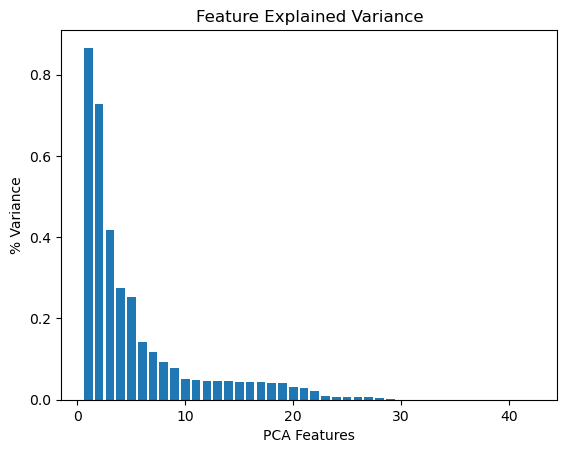

In [14]:
import matplotlib.pyplot as plt
plt.bar(
    range(1,len(pca.explained_variance_ratio_)+1),
    pca.explained_variance_ ## this function returns the variance for each PCA component
    )
 
 
plt.xlabel('PCA Features')
plt.ylabel('% Variance')
plt.title('Feature Explained Variance')
plt.show()

This plot shows us that the first 5/6 PCA components retain at least the 70% of the variance.

Let's visualise a more clear plot...

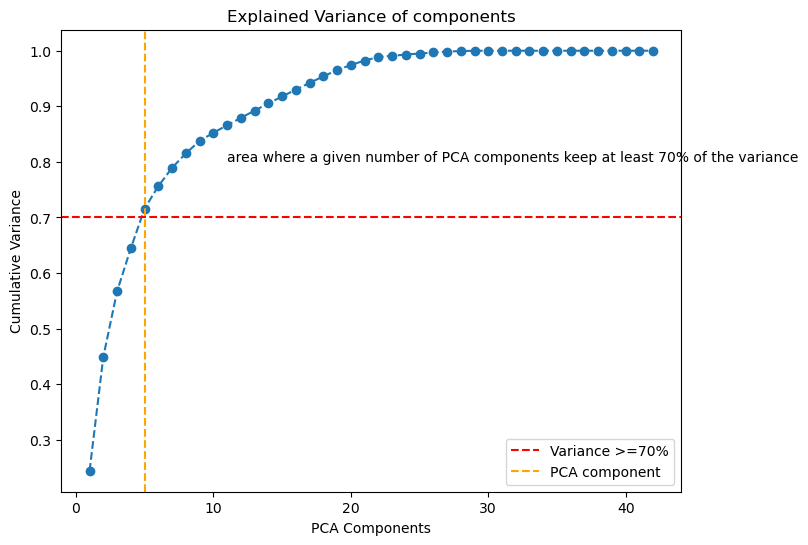

In [15]:
plt.figure(figsize=(8,6))
plt.plot(range(1,43),pca.explained_variance_ratio_.cumsum(),marker='o',linestyle='--')
plt.axhline(y = 0.7, color = 'r', linestyle = '--',label='Variance >=70%')
plt.axvline(x = 5, color = 'orange', linestyle = '--',label = 'PCA component')
plt.title('Explained Variance of components')
plt.xlabel('PCA Components')
plt.ylabel('Cumulative Variance')
plt.text(11,0.8,'area where a given number of PCA components keep at least 70% of the variance',fontsize=10)
plt.legend()
plt.show()

This plot shows us how cumulative sum of the variance changes variance changes as components change.<br>
So fixing a number of components at least equal to 7 we preserve at least 70 % of the total variance of this system.

Text(0, 0.5, 'PCA 2')

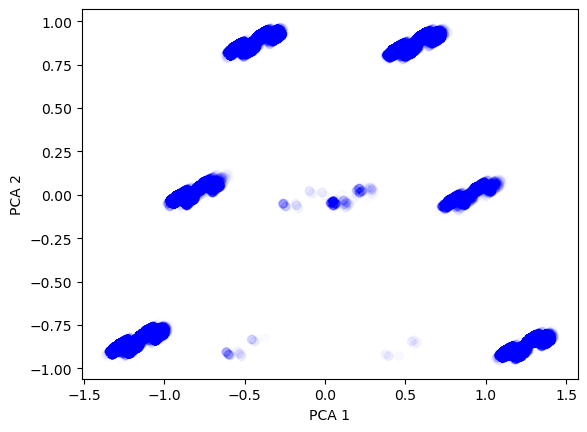

In [16]:
plt.scatter(data.iloc[:,0], data.iloc[:,1], alpha=0.01, color='blue')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

Plotting the scatter plot of the 1st and 2nd PCA componets (those that have the highest percentage of the system variance), it seems that there might be **3 clusters** for these data at least.

In [17]:
pca=PCA(n_components=5) ## reduce dimensionality to 5 components
pca.fit(df_norm)
pca_features=pca.transform(df_norm)

In [260]:
pd.DataFrame(pca_features,index=df.index).to_csv('PCA.csv',sep='\t')

In [18]:
pd.read_csv('PCA.csv',sep='\t',index_col='CustomerID')

,0,1,2,3,4
CustomerID,,,,,
C5841053,0.590407,0.917976,0.838396,0.331307,-0.426176
C2142763,-0.954054,-0.032658,-0.342885,0.331565,-0.221917
C4417068,0.670417,0.908451,0.934913,0.377273,0.759739
C5342380,1.373917,-0.824815,0.962303,0.425406,0.721184
C9031234,-0.409791,0.925498,0.966704,0.325003,-0.364072
...,...,...,...,...,...
C5028150,-1.315978,-0.883864,-0.256925,0.626646,-0.229484
C1034220,-1.253464,-0.876593,-0.155657,0.674196,0.933115
C8020229,-0.573740,0.850573,-0.435030,0.615596,-0.257154


### **2.3 Clustering !**

#### **Find an optimal number of clusters**

##### **Elbow Method**
Finding the optimal number of clusters is a crucial step for any unsupervised alghorithm, in which data will be clustered. <br>
Given the **K-Means** Scikit-learn algorithm fo performing clustering we define the following metric:
- $Inertia$, it is the sum of squared distances of samples to their closest cluster center.<br>

<p>We iterate the values of i from 1 to 22 and calculate the values of inertia for each value of i; then we compute the value of the inertia for each i.

In [262]:
wcss=[]
for i in range(1,22):
    k=KMeans(n_clusters=i,init='k-means++',random_state=40)
    k.fit(pca_features)
    wcss.append(k.inertia_)

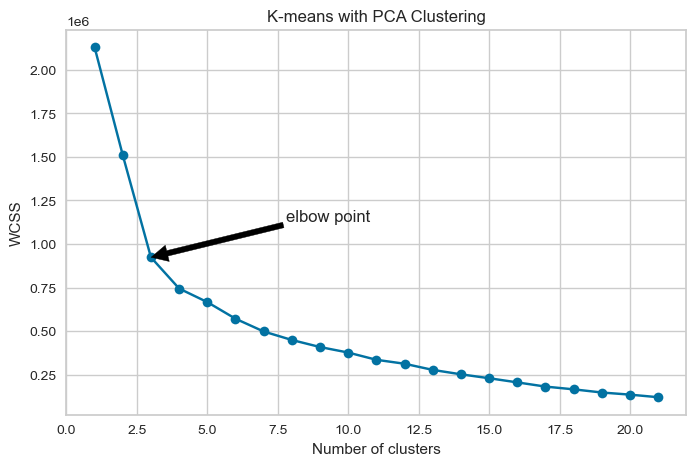

In [263]:
plt.figure(figsize=(8,5))
plt.plot(range(1,22),wcss,marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.title('K-means with PCA Clustering')
plt.annotate('elbow point',(3,wcss[2]),arrowprops=dict(facecolor='black',shrink=0.001),
            horizontalalignment='left',verticalalignment='top',xytext=(7.8,1200000))
plt.show()

To determine the optimal number of clusters, we have to select the value of i at the **“elbow”**, it is the point after which the inertia start decreasing in a linear fashion. Thus for the given data, we conclude that the *optimal number* of clusters for the data could be $3$ or $4$, so we need more deep evaluation to determine the optimal number of clusters.

##### **Silhouette Score**

The Silhouette Score is used to measure the distance between clusters. It shows a measure of how close each point in a cluster is to the other points in the neighbouring clusters. <br>
This metric has a range $[-1,1]$ and it is really effective to analyze difference and similarity between clusters; this score is evaluate for each sample and composed by two scores:<br>
- $a$: The mean distance between a sample and all other points in the same cluster. (intra-cluster distance)
- $b$: The mean distance between a sample and all other points in the next closest cluster.
So the Silhouette Score for each sample is:


$$ S=\frac{(b-a)}{max(a,b)} $$<br>

The score is higher when clusters are well separated and defined, so *High is better*.


In [277]:
for i in range(2,5):
    k=KMeans(n_clusters=i,init='k-means++',random_state=40)
    k.fit(pca_features)
    pred = k.predict(pca_features)
    score = metrics.silhouette_score(pca_features,pred)
    print('Silhouette Score for k = {}: {:<.3f}'.format(k, score))
    


Silhouette Score for k = KMeans(n_clusters=2, random_state=40): 0.290
Silhouette Score for k = KMeans(n_clusters=3, random_state=40): 0.429
Silhouette Score for k = KMeans(n_clusters=4, random_state=40): 0.428


As we expected *Silhouette Score* when n_clusters is 3 or 4 are almost the same so we can coclude that the most **optimal number** of clusters is $3$.

##### **Intercluster Distance**

Intercluster distance is the distance between two data points belonging to two different clusters. In this way we can understand better if results got from Elbow method is accurate or not.

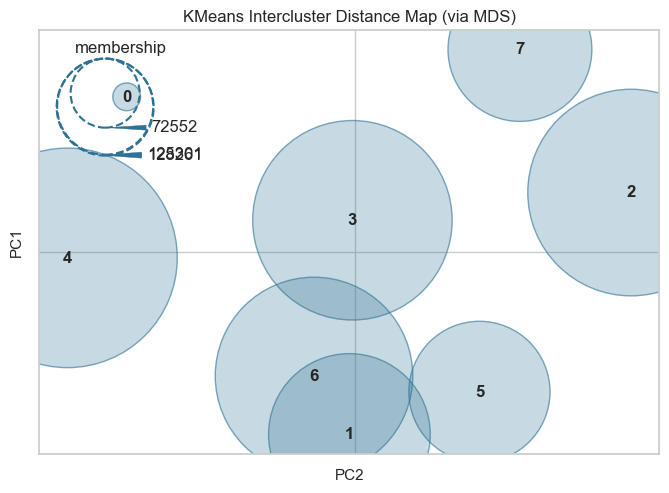

<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [37]:
from yellowbrick.cluster import InterclusterDistance


model = KMeans(8)
visualizer = InterclusterDistance(model, legend_loc='upper left')

visualizer.fit(pca_features)        # Fit the data to the visualizer
visualizer.show()       # Finalize and render the figure

This function provides an embedding of the cluster centers in a 2-dimensional space where the distance between the clusters' centers is preserved. Closer the centers are, closers they are in the original
features space; furthermore the clusters are sized according to a particular metric based on the number of points belonging to a certain center. However even if two clusters overlap in this 2-dimesional space,
it does not imply that they overlap in the original space.
So considering clusters' size whe notice that $4$, $6$, $2$, $3$ are the most relevant according to this plot; so we conclude that 3 or 4 clusters fitting well with our model (as we expected according to previous analysis).




#### **K-Means from scratch**

The most important steps to implement this algorithm are:
1. **Initialization of the centers**, pick k-data points from the dataset where k is equal to the number of clusters.
2. **Closest array**, set an numpy array which has lenght equal to the numbers of samples, it will be useful to label each data point with the closest center.
3. Compute distances between all the points and centers with **euclidean distance**.
4. Update **Closest array** assigning each point to one of the three centers.
5. Repeat until **convergence** 2 and 3 steps.

In [19]:
def KMEANS (X_train,k):

    n=X_train.shape[0]
    p=X_train.shape[1]

    centers = X_train[np.random.choice(n,k,replace=False)] # init centers randomly
    closest = np.zeros(n).astype(int)
    while True: ## while not converged
        prev_closest = closest.copy()
        #print(closest)
        distances=np.sqrt(np.sum(np.abs(X_train.reshape(n,1,p)-centers.reshape(1,k,p))**2,axis=2)) ## compute euclidean distance
        closest = np.argmin(distances,axis=1) # update clusters membership
        for i in range(k):
            centers[i,:] = X_train[closest==i].mean(axis=0) # update centers
        if all(closest == prev_closest): ## convergence rule
            break
    return closest, centers

#### **Run the algorithm**

In [28]:
np.random.seed(84632) ## set the seed for reproducibilty (getting the same result in each simulation)
closest,centers = KMEANS(pca_features,3)

In [30]:
df_kmeans=pd.concat([dataset.reset_index(drop=True),pd.DataFrame(pca_features)],axis=1)
df_kmeans['Clusters_Scratch'] = closest ## label each CustomerID to a cluster
df_kmeans

,Number_Transactions,Transactions>100,AverageAmountTransactions,AverageBalance,Utilization,MostCommonGender,MostCommonLocation,AverageTransaction(INR),AverageBalance(INR),AverageHourTransaction,...,NumberTransactions>Balance,NumberTransactions>=20h,CustomersAge,NumberUsers,0,1,2,3,4,Clusters_Scratch
0,1,0,0.31,218.18,217.87,F,JAMSHEDPUR,25.0,17819.050,14,...,0,0,28,1,0.590407,0.917976,0.838398,0.331284,-0.426136,0
1,1,1,342.83,27.80,315.03,M,JHAJJAR,27999.0,2270.690,14,...,1,0,66,1,-0.954054,-0.032658,-0.342879,0.331553,-0.221873,1
2,1,0,5.62,218.86,213.24,F,MUMBAI,459.0,17874.440,14,...,0,0,26,1,0.670417,0.908451,0.934916,0.377247,0.759773,0
3,2,0,17.99,5324.47,5306.48,F,MUMBAI,1469.2,434849.495,17,...,0,0,46,2,1.373917,-0.824816,0.962307,0.425380,0.721217,2
4,1,0,21.58,82.21,60.63,F,NAVI MUMBAI,1762.5,6714.430,18,...,0,0,35,1,-0.409791,0.925498,0.966706,0.324981,-0.364031,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
839076,1,0,36.73,5.69,31.04,M,PUNE,3000.0,464.870,18,...,1,0,43,1,-1.315978,-0.883864,-0.256927,0.626651,-0.229475,1
839077,1,0,18.37,14.85,3.52,M,BANGALORE,1500.0,1212.700,18,...,1,0,30,1,-1.253464,-0.876593,-0.155657,0.674200,0.933124,1
839078,1,0,9.78,93.49,83.71,M,NEW DELHI,799.0,7635.190,18,...,0,0,32,1,-0.573740,0.850572,-0.435031,0.615600,-0.257149,0
839079,1,0,5.63,334.41,328.78,M,NASHIK,460.0,27311.420,18,...,0,0,31,1,0.428863,0.843204,-0.562289,0.622625,-0.318266,0


Let's visualize through a scatter-plot the clusters...

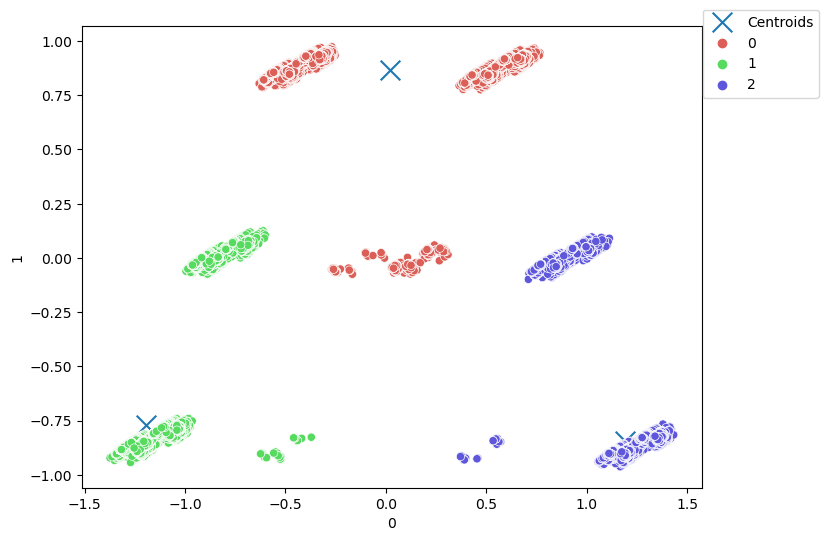

In [31]:
plt.figure(figsize=(8,6))
ax=plt.scatter(centers[:,0],centers[:,1], marker='x', s=200, label= 'Centroids')
sns.scatterplot(x=df_kmeans[0], y=df_kmeans[1],
                hue=df_kmeans['Clusters_Scratch'],palette=sns.color_palette('hls',3))

plt.legend(bbox_to_anchor=(1.20, 1.05))
plt.show()

This scatter plor show us the data divided by the three clusters; the K_Means algorithm seems group the points in 3 different clusters around the centroids; in this case PCA analysis and normalization <br>
have reduced spreading of the data, so the K-Means need just 4/5 iterations to converge.

#### **K-Means++**

<p>Now we implement a version of K_Means **(K-Means ++)** provided by Scikit-learn library.<br>
<p>The difference between this algorithm and the first one is the inizialization: if previously the inizialization was random from data for initial centroids, now this step is different.<br>
K-Means ++ selects initial cluster centroids using sampling based on an empirical probability distribution of the points’ contribution to the overall inertia. This technique speeds up convergence.

In [270]:
k=KMeans(n_clusters=3, init='k-means++',random_state=42)
k=k.fit(pca_features)
centers = k.cluster_centers_

In [271]:
k.predict(pca_features)

array([1, 0, 1, ..., 1, 1, 1])

In [272]:
df_kmeans['Clusters_KMEANS++']=k.labels_ ## appending to the dataset a column which encode the label of each CustomerID

Let's visualise results through a scatter plot..

In [273]:
df_kmeans

,Number_Transactions,Transactions>100,AverageAmountTransactions,AverageBalance,Utilization,MostCommonGender,MostCommonLocation,AverageTransaction(INR),AverageBalance(INR),AverageHourTransaction,...,NumberTransactions>=20h,CustomersAge,NumberUsers,0,1,2,3,4,Clusters_Scratch,Clusters_KMEANS++
0,1,0,0.31,218.18,217.87,F,JAMSHEDPUR,25.0,17819.050,14,...,0,28,1,0.590407,0.917976,0.838397,0.331291,-0.426203,0,1
1,1,1,342.83,27.80,315.03,M,JHAJJAR,27999.0,2270.690,14,...,0,66,1,-0.954054,-0.032658,-0.342882,0.331567,-0.221956,1,0
2,1,0,5.62,218.86,213.24,F,MUMBAI,459.0,17874.440,14,...,0,26,1,0.670417,0.908451,0.934914,0.377259,0.759708,0,1
3,2,0,17.99,5324.47,5306.48,F,MUMBAI,1469.2,434849.495,17,...,0,46,2,1.373917,-0.824816,0.962306,0.425397,0.721147,2,2
4,1,0,21.58,82.21,60.63,F,NAVI MUMBAI,1762.5,6714.430,18,...,0,35,1,-0.409791,0.925498,0.966705,0.324991,-0.364101,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
839076,1,0,36.73,5.69,31.04,M,PUNE,3000.0,464.870,18,...,0,43,1,-1.315978,-0.883864,-0.256925,0.626648,-0.229484,1,0
839077,1,0,18.37,14.85,3.52,M,BANGALORE,1500.0,1212.700,18,...,0,30,1,-1.253464,-0.876593,-0.155657,0.674193,0.933116,1,0
839078,1,0,9.78,93.49,83.71,M,NEW DELHI,799.0,7635.190,18,...,0,32,1,-0.573740,0.850572,-0.435030,0.615597,-0.257154,0,1
839079,1,0,5.63,334.41,328.78,M,NASHIK,460.0,27311.420,18,...,0,31,1,0.428863,0.843204,-0.562288,0.622622,-0.318272,0,1


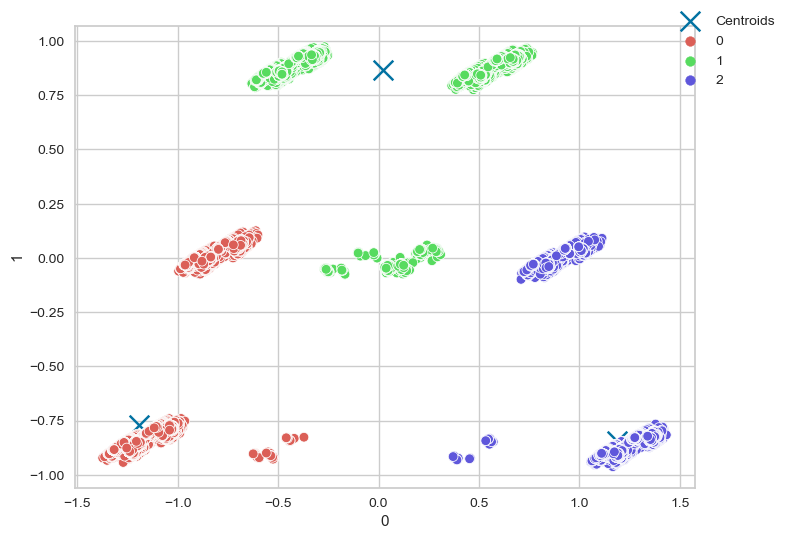

In [274]:
x=df_kmeans[0]
y=df_kmeans[1]
plt.figure(figsize=(8,6))
ax=plt.scatter(centers[:,0],centers[:,1], marker='x', s=200, label= 'Centroids')
sns.scatterplot(x=x,y=y,hue=df_kmeans['Clusters_KMEANS++'],palette=sns.color_palette('hls',3))

plt.legend(bbox_to_anchor=(1.15, 1.05))
plt.show()


According to this plot there are no significant differences between the k-means scatter plot from scratch randomly initialized and k-means ++. This is probably due to the reduction of the dimensionality which allowed to find the most optimal clusters independently from the initialization. Furthermore the speed gain is not significant got from empirical probability distribution.

### **2.4 Analysing your results!**

Let's do **Characterizing Clusters step** in order to explain the main characteristics that our clusters have.

We pick **MostCommonGender**, **Balance_greater_Q3**, **Balance_less_Q1**, **Balance_between_Q1_Q3**, **Transaction>50%Balance** and  **Transaction_less_50%Balance** to identify the clusters for customers.

##### **PIVOT TABLES**

In [275]:
## drop PCA components because now they are not useful anymore for our analysis
df_kmeans.drop([0,1,2,3,4],axis=1,inplace=True) 

In [276]:
df_kmeans

,Number_Transactions,Transactions>100,AverageAmountTransactions,AverageBalance,Utilization,MostCommonGender,MostCommonLocation,AverageTransaction(INR),AverageBalance(INR),AverageHourTransaction,...,Balance_less_median,Transaction<10%Balance,Transaction>50%Balance,Transaction_less_50%Balance,NumberTransactions>Balance,NumberTransactions>=20h,CustomersAge,NumberUsers,Clusters_Scratch,Clusters_KMEANS++
0,1,0,0.31,218.18,217.87,F,JAMSHEDPUR,25.0,17819.050,14,...,0,1,0,1,0,0,28,1,0,1
1,1,1,342.83,27.80,315.03,M,JHAJJAR,27999.0,2270.690,14,...,1,0,1,0,1,0,66,1,1,0
2,1,0,5.62,218.86,213.24,F,MUMBAI,459.0,17874.440,14,...,0,1,0,1,0,0,26,1,0,1
3,2,0,17.99,5324.47,5306.48,F,MUMBAI,1469.2,434849.495,17,...,0,1,0,2,0,0,46,2,2,2
4,1,0,21.58,82.21,60.63,F,NAVI MUMBAI,1762.5,6714.430,18,...,1,0,0,1,0,0,35,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
839076,1,0,36.73,5.69,31.04,M,PUNE,3000.0,464.870,18,...,1,0,1,0,1,0,43,1,1,0
839077,1,0,18.37,14.85,3.52,M,BANGALORE,1500.0,1212.700,18,...,1,0,1,0,1,0,30,1,1,0
839078,1,0,9.78,93.49,83.71,M,NEW DELHI,799.0,7635.190,18,...,1,0,0,1,0,0,32,1,0,1
839079,1,0,5.63,334.41,328.78,M,NASHIK,460.0,27311.420,18,...,0,1,0,1,0,0,31,1,0,1


We decide to evaluate the percentage of number of CustomerIDs belonging to the three clusters according to different variable like the gender or balance.

In [46]:
table_gender = df_kmeans.pivot_table(index='Clusters_Scratch',values='AverageBalance',columns=['MostCommonGender'],aggfunc='count').fillna(0)
table_gender.rename(columns={'M':'% M','F':'% F'},inplace=True)
round(table_gender.iloc[:,0:4].div(table_gender.iloc[:,0:4].apply(lambda x : np.sum(x),axis=1),axis=0),4).mul(100) ## the sum of the row should be 100 

MostCommonGender,% F,% M
Clusters_Scratch,,
0,31.66,68.34
1,24.03,75.97
2,33.92,66.08


Considering the most common gender of each CustomerID we see that there is no clear separation between Male and Female among the three different clusters. In fact the percentage is equally distributed in all of three.

Let's analyse for relationship between **balance** and **transaction** this time, in particular if a CustomerID used to spend the 50% of his balance in a singular transaction, considering as always the percentage of CustomerIDs among the clusters.

In [55]:
table_transaction = df_kmeans.pivot_table('AverageBalance',index='Clusters_Scratch',columns='Transaction>50%Balance',aggfunc='count').fillna(0)
table_transaction.rename(columns={0:'% NO',1:'% YES'},inplace=True)
round(table_transaction.iloc[:,0:2].div(table_transaction.iloc[:,0:2].apply(lambda x : np.sum(x),axis=1),axis=0),4).mul(100) ## the sum of the row should be 100 

Transaction>50%Balance,% NO,% YES
Clusters_Scratch,,
0,95.27,4.73
1,55.25,44.75
2,97.05,2.95


In [54]:
table_Q3 = df_kmeans.pivot_table('AverageBalance',index='Clusters_Scratch',columns='Transaction_less_50%Balance',aggfunc='count').fillna(0)
table_Q3.rename(columns={0:'% NO',1:'% YES'},inplace=True)
round(table_Q3.iloc[:,0:2].div(table_Q3.iloc[:,0:2].apply(lambda x : np.sum(x),axis=1),axis=0),4).mul(100) ## the sum of the row should be 100 

Transaction_less_50%Balance,% NO,% YES
Clusters_Scratch,,
0,1.04,98.96
1,42.69,57.31
2,0.27,99.73


Above  we can see that the percentage of *% No*, Customers which do not usually spend more than 50 % of their balance, is concentrated within the first and third clusters. The second one is more balance between *% Yes* and *% No*. So there is a clear separation of customers, based on their **behavior**, within the clusters.

We now only analyze the distribution of customers according **only to their balance** among the various clusters.

In [ ]:
table_Q3 = df_kmeans.pivot_table('AverageBalance',index='Clusters_Scratch',columns='Transaction>50%Balance',aggfunc='count').fillna(0)
table_Q3.rename(columns={0:'% NO',1:'% YES'},inplace=True)
round(table_Q3.iloc[:,0:2].div(table_Q3.iloc[:,0:2].apply(lambda x : np.sum(x),axis=1),axis=0),4).mul(100) ## the sum of the row should be 100 

In [56]:
### print quantiles' values
print('The first quantile (Q1) is: ',dataset.AverageBalance.quantile(0.25))
print('The third quantile (Q3) is: ',dataset.AverageBalance.quantile(0.75))

The first quantile (Q1) is:  65.71
The third quantile (Q3) is:  700.83


In [52]:
table_Q3 = df_kmeans.pivot_table('AverageBalance',index='Clusters_Scratch',columns='Balance_greater_Q3',aggfunc='count').fillna(0)
table_Q3.rename(columns={0:'% NO',1:'% YES'},inplace=True)
round(table_Q3.iloc[:,0:2].div(table_Q3.iloc[:,0:2].apply(lambda x : np.sum(x),axis=1),axis=0),4).mul(100) ## the sum of the row should be 100 

Balance_greater_Q3,% NO,% YES
Clusters_Scratch,,
0,100.00,0.00
1,100.00,0.00
2,1.94,98.06


In [49]:
table_Q1 = df_kmeans.pivot_table(index='Clusters_Scratch',values='AverageBalance',columns='Balance_less_Q1',aggfunc='count').fillna(0)
table_Q1.rename(columns={0:'% NO',1:'% YES'},inplace=True)
round(table_Q1.iloc[:,0:2].div(table_Q1.iloc[:,0:2].apply(lambda x : np.sum(x),axis=1),axis=0),4).mul(100) ## the sum of the row should be 100 

Balance_less_Q1,% NO,% YES
Clusters_Scratch,,
0,100.0,0.0
1,4.7,95.3
2,100.0,0.0


In [50]:
tableQ1_Q3 = df_kmeans.pivot_table(index='Clusters_Scratch',values='AverageBalance',columns='Balance_between_Q1_Q3',aggfunc='count').fillna(0)
tableQ1_Q3.rename(columns={0:'% NO',1:'% YES'},inplace=True)
round(tableQ1_Q3.iloc[:,0:4].div(tableQ1_Q3.iloc[:,0:4].apply(lambda x : np.sum(x),axis=1),axis=0),4).mul(100)

Balance_between_Q1_Q3,% NO,% YES
Clusters_Scratch,,
0,0.00,100.00
1,95.30,4.70
2,98.06,1.94


Considering only the balance, we observe that our clustering model provides really good results by dividing customers according to their balance.<br>
In this case we notice that the first cluster groups all customers with balance between Q1 and Q3, the second one groups almost all customers with balance lower than Q1 and the third one groups the richest customers.
So we conclude that our model works well in dividing CustomerIDs according to their balance and their their habits on spending.


##### **Evaluation Clustering Performance**

In [57]:
from sklearn import metrics 

Since we don not have any information about the real labels of the model, we must use metrics that do not require the a-priori knowledge of the **ground-truth labels** ... 

**Silhouette Score**

we can use this metric to evaluate our model as well as to find out the optimal number of clusters. As seen previously it shows a measure of how close each point in a cluster is to the other points in the neighbouring clusters.<br>
This metric has a range $[-1,1]$ and it is really effective to analyze difference and similarity between clusters; this score is evaluate for each sample and composed by two scores:<br>
- $a$: The mean distance between a sample and all other points in the same cluster. (intra-cluster distance)
- $b$: The mean distance between a sample and all other points in the next closest cluster.
So the Silhouette Score for each sample is:


$$ S=\frac{(b-a)}{max(a,b)} $$<br>

The higher the Silhouette Coefficients (the closer to +1), the further away the cluster’s samples are from the neighbouring clusters samples. A value of 0 indicates that the sample is very close to the decision boundary between two neighbouring clusters (overlapping). Negative values, instead, indicate that data points are likely assigned to the wrong cluster. Averaging the Silhouette Coefficients, we can get to a global Silhouette Score which can be used to describe the entire population’s performance with a single value.



In [277]:
for i in range(2,5):
    k=KMeans(n_clusters=i,init='k-means++',random_state=40)
    k.fit(pca_features)
    pred = k.predict(pca_features)
    score = metrics.silhouette_score(pca_features,pred)
    print('Silhouette Score for k = {}: {:<.3f}'.format(k, score))
    


Silhouette Score for k = KMeans(n_clusters=2, random_state=40): 0.290
Silhouette Score for k = KMeans(n_clusters=3, random_state=40): 0.429
Silhouette Score for k = KMeans(n_clusters=4, random_state=40): 0.428


When the number clusters is equal to 3 whe get the maximum value for the Silhouette Score ($0.429$). Since the score is bigger than 0 the clusters are well separated without having overlapping between samples belonging to neighbouring clusters.

**Calinski-Harabasz Index**

The *Calinski-Harabasz* Index is defined as the index of the sum of intra-cluster dispersion and inter-cluster dispersion for all clusters, where dispersion is defined as the sum of distances squared.<br>
Also in this case *higher is better* because when the score is higher it means that the clusters are well separated and dense.

In [73]:
kmeans_model = KMeans(n_clusters=3, random_state=42).fit(pca_features)
labels = kmeans_model.labels_
metrics.calinski_harabasz_score(pca_features, labels)

548248.5591337959

## **Command Line Question**

In [17]:
data = pd.read_csv('bank_transactions.csv')

In [20]:
data.rename(columns={"TransactionAmount (INR)": "TransactionAmount"}, inplace=True)

### **Which location has the maximum number of purchases been made ?**

In [11]:
data.groupby('CustLocation')['CustLocation'].count().sort_values(ascending =False).head(1)

CustLocation
MUMBAI    103595
Name: CustLocation, dtype: int64

### **In the dataset provided, did females spend more than males, or vice versa?**

In [26]:
data.groupby('CustGender').TransactionAmount.sum().sort_values(ascending =False).head(1)

CustGender
M    1.181645e+09
Name: TransactionAmount, dtype: float64

### **Report the customer with the highest average transaction amount in the dataset.**

In [25]:
data.groupby('CustomerID').TransactionAmount.mean().sort_values(ascending =False).head(1)

CustomerID
C7319271    1560034.99
Name: TransactionAmount, dtype: float64

## **Algorithmic Question**

In [21]:
from collections import Counter

In [22]:
def entrances(M):
    
    # function that creates a list of the sequence of entrances
    lst = []
    for i in range(M):
        lst.append(int(input()))
    return lst

In [23]:
def restrictions():
    
    # number of entrances
    n_entr = int(input())
    
    # number of students
    n_stud = int(input())
    
    # number of guards
    n_guards = int(input())
    
    # sequence of entrances
    entr = entrances(n_stud)
    
    # fixed counter that counts the distinct entrances
    count_dict = dict(Counter(entr).items())
    
    # count of occurences that increases for each distinct entrance
    count={el:0 for el in entr}
    
    # track and check if an entrance it's open/close (by default it's closed)
    open_close={el: 'closed' for el in entr}
    
    # track and check if a guard is needed (add it to the list and if he's busy or free
    guards_needed = []
    
    # for each entrance
    for el in entr:
        
        # we increse the count
        count[el]+=1
        
        # if the first student arrives at the entrance, that is the door is closed
        if open_close[el] == 'closed':
            
            # we open the door 
            open_close[el] = 'opened'
            
            # if a previous busy guard is free
            if any(item == 'free' for item in guards_needed):
                
                # we assing that guard to this entrance, that is he becomes busy
                guards_needed[guards_needed.index('free')]= 'busy'
                
            # if there are no free guards    
            else:
                
                # we add a new guard
                guards_needed.append('busy') 
                
        # if the last student arrives at the entrance, that is the count of that entrance reaches the max        
        if count[el] == count_dict[el]:
            
            # we close the door
            open_close[el] = 'closed'
            
            # and that guard becomes available
            guards_needed[guards_needed.index('busy')]= 'free'
            
    # if the number of guards is equal to the guards needed        
    if n_guards == len(guards_needed):
        
        # we print yes 
        print('YES')
    else:
        
        # else we need more/less guards
        print('NO')

In [24]:
restrictions() # example 1

4
5
1
1
1
3
3
3
YES


In [25]:
restrictions() # example 2

2
5
1
1
2
1
2
2
NO
